In [155]:
! pip install torchinfo
from torchinfo import summary

# Attention Head
* so in transformer we do use multiplicative attention ,there are two type of attention one is additive and other is scale dot attention
* so in research paper  "attention all u need" they hav incorported multiplicative attention
* i assume it just involves addition rather than the multiplication to calculate the score

dimension of data (directly proportional to) variance

hence the scailing down is down by (dimension of model)**(1/2)


In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import torch
import numpy as np

In [158]:

device = "cuda" if torch.cuda.is_available() else "cpu"

In [159]:
#utility function look ahead mask
def create_look_ahead_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask  # shape: (seq_len, seq_len)


In [160]:
create_look_ahead_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [161]:
#it has been modified to process the 3d data where the data across the z index correspond to each head

def attention_head(queries, keys, values, dropout=None, mask=None):

  # Calculate the attention scores
  # Scores will have shape (batch_size * sequence_length, batch_size * sequence_length)
  d_k = keys.size(-1)
  scores = torch.matmul(queries, keys.transpose(-2, -1))
  scores = scores / d_k**0.5
#now this look ahead mask will be used in the decoder
  if mask is not None:
# mask should be broadcastable to the shape of the scores tensor
# for 3d input, the mask should have shape (num_heads,batch_size * sequence_length, batch_size * sequence_length)
    scores=scores+mask
  # row mean -1 and -2 means col
  scores = scores.softmax(dim=-1) # apply softmax across the row dimension (keys)


  # Apply dropout
  if dropout is not None:
      scores = dropout(scores)

  # Apply scores to values
  weighted_sum = torch.matmul(scores, values)

  return weighted_sum

### we will test our attention head with custom args

In [162]:
import torch

In [163]:
# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Create sample input tensors with compatible shapes
# Embeddings are now 2D: (batch_size * sequence_length, embedding_dim)
sample_embeddings = torch.randn(batch_size * sequence_length, embedding_dim)

# Create dummy linear layers that output the expected shape for attention_head
# The linear layers now expect an input shape of (batch_size * sequence_length, embedding_dim)
# and output a shape of (batch_size * sequence_length, head_dim)
dummy_key_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_query_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_value_linear = torch.nn.Linear(embedding_dim, head_dim)

# Create a dummy dropout layer
dummy_dropout = torch.nn.Dropout(0.1)

# Create a dummy mask
# The mask should have shape (batch_size * sequence_length, batch_size * sequence_length) for 2D input
dummy_mask=create_look_ahead_mask(batch_size*sequence_length)
print(dummy_mask)

# Pass the sample_embeddings through the dummy linear layers to get the keys, queries, and values tensors
# These tensors should have shape (batch_size * sequence_length, head_dim)
sample_keys = dummy_key_linear(sample_embeddings)
sample_queries = dummy_query_linear(sample_embeddings)
sample_values = dummy_value_linear(sample_embeddings)

print("Sample Keys Shape:", sample_keys.shape)
print("Sample Queries Shape:", sample_queries.shape)
print("Sample Values Shape:", sample_values.shape)

# Test the attention_head function with the compatible inputs

  # attention_head now expects 2D inputs for keys, queries, and values
attention_output = attention_head(sample_queries, sample_keys, sample_values, dummy_dropout, mask=dummy_mask)
print("Attention head output shape:", attention_output)


tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0.]])
Sample Keys Shape: torch.Size([6, 2])
Sample Queries Shape: torch.Size([6, 2])
Sample Values Shape: torch.Size([6, 2])
Attention head output shape: tensor([[ 0.0000,  0.0000],
        [ 0.1531, -0.3321],
        [ 0.0275, -0.5066],
        [-0.2021, -0.5648],
        [-0.0125, -0.3495],
        [-0.1132, -0.3625]], grad_fn=<MmBackward0>)


# testing for the 3d inputs

In [164]:
# Define input dimensions
batch_size = 12
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Create sample input tensors with compatible shapes
# Embeddings are now 2D: (batch_size * sequence_length, embedding_dim)
sample_embeddings = torch.randn(batch_size,sequence_length, embedding_dim)

# Create dummy linear layers that output the expected shape for attention_head
# The linear layers now expect an input shape of (batch_size * sequence_length, embedding_dim)
# and output a shape of (batch_size * sequence_length, head_dim)
dummy_key_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_query_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_value_linear = torch.nn.Linear(embedding_dim, head_dim)

# Create a dummy dropout layer
dummy_dropout = torch.nn.Dropout(0.1)

# Create a dummy mask
# The mask should have shape (batch_size * sequence_length, batch_size * sequence_length) for 2D input
dummy_mask = torch.tile(create_look_ahead_mask(sequence_length),(batch_size,1,1)) # Assuming no masking for simplicity
print(dummy_mask.shape)
# Pass the sample_embeddings through the dummy linear layers to get the keys, queries, and values tensors
# These tensors should have shape (batch_size * sequence_length, head_dim)
sample_keys = dummy_key_linear(sample_embeddings)
sample_queries = dummy_query_linear(sample_embeddings)
sample_values = dummy_value_linear(sample_embeddings)

print("Sample Keys Shape:", sample_keys.shape)
print("Sample Queries Shape:", sample_queries.shape)
print("Sample Values Shape:", sample_values.shape)

# Test the attention_head function with the compatible inputs

  # attention_head now expects 2D inputs for keys, queries, and values
attention_output = attention_head(sample_queries, sample_keys, sample_values, dummy_dropout, dummy_mask)
print("Attention head output shape:", attention_output.shape)


torch.Size([12, 3, 3])
Sample Keys Shape: torch.Size([12, 3, 2])
Sample Queries Shape: torch.Size([12, 3, 2])
Sample Values Shape: torch.Size([12, 3, 2])
Attention head output shape: torch.Size([12, 3, 2])


# Multi Head Attention
#### we create tunable parameters for each head one for query ,key and value

In [165]:
import torch.nn as nn


class MultiHeadAttention(nn.Module):
  def __init__(self,heads,d_model,dropout=0.01,mask=None):
     super(MultiHeadAttention,self).__init__();
     self.heads=heads;
     self.d_model=d_model;
     self.d_key=d_model//heads;
     # Linear layers for query, key, value, and projection
     self.query_linears = nn.Linear(d_model, d_model)
     self.key_linears   = nn.Linear(d_model, d_model)
     self.value_linears = nn.Linear(d_model, d_model)
     self.mask=mask
     #prjection layer will be used to project the concatenated output of all heads to the end of attention in the multihead attention
     self.projection_layer=nn.Linear(d_model,self.d_model)
     #this field is for debugging purposes
     self.attn=None
     self.dropout=nn.Dropout(dropout);

  def forward(self,input_embedding,encoder_output_embedding=None):
    head_dim=self.d_model//self.heads;
    #batch_size,sentence length and embedding dimension calculate
    batch_size=input_embedding.size(0)
    sentence_len=input_embedding.size(1)
    embedding_dim=input_embedding.size(2)
    queries=self.query_linears(input_embedding).reshape(batch_size,sentence_len,self.heads,head_dim).permute(2,0,1,3);
    keys=self.key_linears(input_embedding)if(encoder_output_embedding==None) else self.key_linears(encoder_output_embedding);
    values=self.value_linears(input_embedding) if(encoder_output_embedding==None) else self.value_linears(encoder_output_embedding);
    #now reshpae the keys and value matrix
    keys=keys.reshape(batch_size,sentence_len,self.heads,head_dim).permute(2,0,1,3);
    values=values.reshape(batch_size,sentence_len,self.heads,head_dim).permute(2,0,1,3);
    dropout = torch.nn.Dropout(0.1)
    result=attention_head(queries,keys,values,dropout=dropout,mask=self.mask).permute(1,2,0,3).reshape(batch_size,sentence_len,self.heads*head_dim);

    return self.projection_layer(result)


In [166]:
import torch

# Define parameters for MultiHeadAttention
heads = 4
d_model = 128 # Make sure d_model is divisible by heads
dropout_prob = 0.1

# Create a dummy input embedding
batch_size = 2
sequence_length = 10
input_embedding = torch.randn(batch_size, sequence_length, d_model)
print(input_embedding.shape)
# Create an instance of MultiHeadAttention
multi_head_attention = MultiHeadAttention(heads, d_model, dropout=dropout_prob)

# Test the forward method
output = multi_head_attention(input_embedding)

print("Input embedding shape:", input_embedding.shape)
print("Output shape:", output.shape)
print(summary(multi_head_attention))

torch.Size([2, 10, 128])
Input embedding shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Layer (type:depth-idx)                   Param #
MultiHeadAttention                       --
├─Linear: 1-1                            16,512
├─Linear: 1-2                            16,512
├─Linear: 1-3                            16,512
├─Linear: 1-4                            16,512
├─Dropout: 1-5                           --
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0


# Adding the add and normalize layer

In [167]:
# this add and normalize layer will be used in the subsidual linkage
# this subisidual is used to acoid the diminishing effect or influence of the original input
#also make sure to use the layer normalization rather than the l2 ,so layer normalization is done on the output of each neuron with similar dimension
def add_norm(prev,input):
  result=prev+input;
  return torch.nn.functional.layer_norm(result);

# Adding the position wise feed forward

In [168]:
import torch.nn as nn
import torch.nn.functional as F

class PositionWiseFFN(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionWiseFFN,self).__init__();
    self.linear1=nn.Linear(d_model,d_ff);
    self.linear2=nn.Linear(d_ff,d_model);
    self.dropout=nn.Dropout(dropout);

  def forward(self,x):
    x=self.linear1(x);
    x=F.gelu(x); # Use F.gelu
    x=self.dropout(x);
    x=self.linear2(x);
    return x;

# test case for the position wise feed forward network

In [169]:
# Test case for PositionWiseFFN

# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
d_ff = 8 # Dimension of the feed-forward hidden layer

# Create sample input tensor with shape (batch_size * sequence_length, embedding_dim)
sample_input = torch.randn(batch_size * sequence_length, embedding_dim)

print("Sample Input Shape for PositionWiseFFN:", sample_input.shape)

# Instantiate the PositionWiseFFN module
position_wise_ffn = PositionWiseFFN(d_model=embedding_dim, d_ff=d_ff)

# Pass the sample input through the PositionWiseFFN module

print(sample_input)
output_ffn = position_wise_ffn(sample_input)
print("PositionWiseFFN Output Shape:", output_ffn)
print(summary(position_wise_ffn))


Sample Input Shape for PositionWiseFFN: torch.Size([6, 4])
tensor([[-0.8644, -0.7435, -0.2489,  1.9543],
        [-0.4400, -0.0337,  0.1260,  0.8201],
        [-1.1143, -0.5782,  1.1518,  0.6575],
        [ 0.4564,  1.0201,  0.4519,  1.0084],
        [-0.7985,  1.8244, -0.7479, -1.1923],
        [ 1.3602, -1.0515,  0.7523, -0.9882]])
PositionWiseFFN Output Shape: tensor([[-0.1584,  0.1525, -0.1069,  0.7077],
        [-0.2530,  0.1406,  0.0164,  0.5528],
        [-0.4686,  0.2191,  0.0508,  0.9939],
        [ 0.1015,  0.1505,  0.3590,  0.5410],
        [-0.1740,  0.0722,  0.1057,  0.2095],
        [-0.9952, -0.0436,  0.0758,  0.1541]], grad_fn=<AddmmBackward0>)
Layer (type:depth-idx)                   Param #
PositionWiseFFN                          --
├─Linear: 1-1                            40
├─Linear: 1-2                            36
├─Dropout: 1-3                           --
Total params: 76
Trainable params: 76
Non-trainable params: 0


# Adding positional encoding

In [170]:
import numpy as np
def get_position_encoding(seq_len, d_model, n=10000):

    P = torch.zeros((seq_len, d_model))

    for pos in range(seq_len):

        for i in range(d_model):

            angle = pos / np.power(n, (2 * (i // 2)) / d_model)

            P[pos, i] = np.sin(angle) if i % 2 == 0 else np.cos(angle)

    return P.to(device)

In [171]:
# Test case for get_position_encoding

# Define parameters for testing
seq_len = 1
d_model = 10

# Get positional encoding
position_encoding = get_position_encoding(seq_len, d_model)

print("Position Encoding Shape:", position_encoding.shape)
print("Position Encoding:\n", position_encoding)

Position Encoding Shape: torch.Size([1, 10])
Position Encoding:
 tensor([[0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]], device='cuda:0')


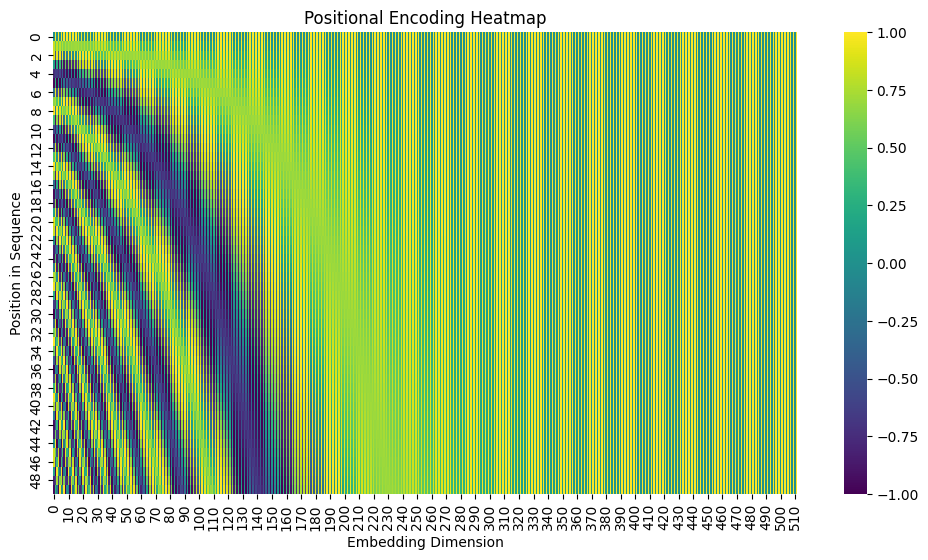

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameters (you can adjust these)
seq_len = 50
d_model = 512

# Get positional encoding
position_encoding = get_position_encoding(seq_len, d_model)

# Visualize the positional encoding
plt.figure(figsize=(12, 6))
sns.heatmap(position_encoding.cpu().numpy(), cmap="viridis")
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.show()

# creating the add and normalisation layer

In [173]:
#normalization has to be the layer normalization
def add_norm(prev,input):
  result=prev+input;
  layer_norm=torch.nn.LayerNorm(input.shape[-1])
  layer_norm=layer_norm.to(device)
  return layer_norm

In [174]:
class AddNorm(nn.Module):
  def __init__(self,d_model):
    super(AddNorm,self).__init__()
    self.layer_norm=torch.nn.LayerNorm(d_model)
  def forward(self,prev,input):
    result=prev+input;
    return self.layer_norm(result)

# Creating the Encoder Sublayer

In [175]:
class EncoderSublayer(nn.Module):
  def __init__(self,d_model,num_heads,ffn_dim) -> None:
    super(EncoderSublayer,self).__init__()
    self.multihead=MultiHeadAttention(heads=num_heads,d_model=d_model)
    self.ffn=PositionWiseFFN(d_model=d_model,d_ff=ffn_dim)
    self.d_model=d_model
    self.ffn_dim=ffn_dim
    self.add_norm1=AddNorm(d_model=d_model)
    self.add_norm2=AddNorm(d_model=d_model)
  def forward(self,input_embeddings):
    add_norm_1=self.add_norm1(prev=input_embeddings,input=self.multihead(input_embeddings))
    add_norm_2=self.add_norm2(prev=add_norm_1,input=self.ffn(add_norm_1))
    return add_norm_2

## Adding the test case for the encoder sublayer

In [176]:
# Test case for EncoderSublayer

# Define input dimensions
batch_size = 10
sequence_length = 100
embedding_dim = 512
num_heads = 8
ffn_dim = 2048 # Dimension of the feed-forward hidden layer

# Create sample input embeddings with shape (batch_size * sequence_length, embedding_dim)
sample_input_embeddings = torch.randn(batch_size , sequence_length, embedding_dim)

print("Sample Input Embeddings Shape for EncoderSublayer:", sample_input_embeddings.shape)

# Instantiate the EncoderSublayer module
encoder_sublayer = EncoderSublayer(d_model=embedding_dim, num_heads=num_heads, ffn_dim=ffn_dim)

# Pass the sample input embeddings through the EncoderSublayer module

output_encoder_sublayer = encoder_sublayer(sample_input_embeddings)
print("EncoderSublayer Output Shape:", output_encoder_sublayer.shape)
# now display the summary of the encoder sublayer
print(summary(encoder_sublayer))


Sample Input Embeddings Shape for EncoderSublayer: torch.Size([10, 100, 512])
EncoderSublayer Output Shape: torch.Size([10, 100, 512])
Layer (type:depth-idx)                   Param #
EncoderSublayer                          --
├─MultiHeadAttention: 1-1                --
│    └─Linear: 2-1                       262,656
│    └─Linear: 2-2                       262,656
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
│    └─Dropout: 2-5                      --
├─PositionWiseFFN: 1-2                   --
│    └─Linear: 2-6                       1,050,624
│    └─Linear: 2-7                       1,049,088
│    └─Dropout: 2-8                      --
├─AddNorm: 1-3                           --
│    └─LayerNorm: 2-9                    1,024
├─AddNorm: 1-4                           --
│    └─LayerNorm: 2-10                   1,024
Total params: 3,152,384
Trainable params: 3,152,384
Non-trainable params: 0


# Creating the Encoder

In [177]:
class Encoder(nn.Module):
  def __init__(self,d_model,num_heads,ffn_dim,num_layers,n=None) -> None:
    super(Encoder,self).__init__()
    self.num_heads=num_heads
    self.num_layers=num_layers
    self.d_model=d_model
    self.ffn_dim=ffn_dim
    self.n=n
    self.add_norm=AddNorm(d_model=d_model)
    self.encoder_layers=nn.Sequential(*[EncoderSublayer(d_model=d_model,num_heads=num_heads,ffn_dim=ffn_dim) for i in range(0,num_layers)]);
  def forward(self,input_embedding):
    pe=None
    if (self.n!=None):
     pe=get_position_encoding(input_embedding.size(-2),self.d_model,self.n)
    else:
     pe=get_position_encoding(input_embedding.size(-2),self.d_model)
    result=self.add_norm(prev=input_embedding,input=pe)
    for i in range(self.num_layers):
      result=self.encoder_layers[i](result)
    return result

## Adding the test case for the Encoder

In [178]:
# Test case for Encoder

# Define input dimensions
batch_size = 10
sequence_length = 100
d_model = 512 # Make sure d_model is divisible by num_heads
num_heads = 8
ffn_dim = 2048 # Dimension of the feed-forward hidden layer
num_layers = 6 # Number of encoder layers

# Create sample input embeddings with shape (batch_size, sequence_length, d_model)
sample_input_embeddings = torch.randn(batch_size, sequence_length, d_model)

print("Sample Input Embeddings Shape for Encoder:", sample_input_embeddings.shape)

# Instantiate the Encoder module
encoder = Encoder(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers).to(device)

# Pass the sample input embeddings through the Encoder module

output_encoder = encoder(sample_input_embeddings.to(device))
print("Encoder Output Shape:", output_encoder.shape)
#display the output of the encoder
print(summary(encoder))


Sample Input Embeddings Shape for Encoder: torch.Size([10, 100, 512])
Encoder Output Shape: torch.Size([10, 100, 512])
Layer (type:depth-idx)                   Param #
Encoder                                  --
├─AddNorm: 1-1                           --
│    └─LayerNorm: 2-1                    1,024
├─Sequential: 1-2                        --
│    └─EncoderSublayer: 2-2              --
│    │    └─MultiHeadAttention: 3-1      1,050,624
│    │    └─PositionWiseFFN: 3-2         2,099,712
│    │    └─AddNorm: 3-3                 1,024
│    │    └─AddNorm: 3-4                 1,024
│    └─EncoderSublayer: 2-3              --
│    │    └─MultiHeadAttention: 3-5      1,050,624
│    │    └─PositionWiseFFN: 3-6         2,099,712
│    │    └─AddNorm: 3-7                 1,024
│    │    └─AddNorm: 3-8                 1,024
│    └─EncoderSublayer: 2-4              --
│    │    └─MultiHeadAttention: 3-9      1,050,624
│    │    └─PositionWiseFFN: 3-10        2,099,712
│    │    └─AddNorm: 3-11  


# Decoder implmentation

# Decoder sublayer impmentation

In [179]:
class DecoderSublayer(nn.Module):
  def __init__(self,batch_size,sentence_len,dim_heads,d_model,ff_dim):
    super(DecoderSublayer,self).__init__();
    self.batch_size=batch_size;
    self.sentence_len=sentence_len;
    self.dim_heads=dim_heads;
    self.d_model=d_model;
    self.ff_dim=ff_dim;
    self.add_norm0=AddNorm(d_model=d_model);
    self.add_norm1=AddNorm(d_model=d_model);
    self.add_norm2=AddNorm(d_model=d_model);
    self.mask=create_look_ahead_mask(seq_len=sentence_len).to(device);
    #first we create the masked multihead attention
    self.masked_head_attention=MultiHeadAttention(heads=dim_heads,d_model=d_model,dropout=0.1,mask=self.mask);
    #second we create the multihead attention
    self.multihead_attention=MultiHeadAttention(heads=dim_heads,d_model=d_model,dropout=0.1);
    self.ffn=PositionWiseFFN(d_model=d_model,d_ff=ff_dim);
  def forward(self,input_embeddings,encoder_output_embedding):
    result1=self.add_norm0(prev=input_embeddings,input=self.masked_head_attention(input_embeddings));
    result_of_cross_attention=self.multihead_attention(result1,encoder_output_embedding);
    result2=self.add_norm1(prev=result1,input=result_of_cross_attention);
    result3=self.add_norm2(prev=result2,input=self.ffn(result2));
    return result3;

In [180]:
# Test case for DecoderSublayer

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer

# Create sample input embeddings with shape (batch_size, sequence_length, d_model)
# Decoder input embeddings
sample_decoder_input_embeddings = torch.randn(batch_size ,sequence_length, d_model)
# Encoder output embeddings (for cross-attention)
sample_encoder_output_embeddings = torch.randn(batch_size ,sequence_length, d_model)


print("Sample Decoder Input Embeddings Shape for DecoderSublayer:", sample_decoder_input_embeddings.shape)
print("Sample Encoder Output Embeddings Shape for DecoderSublayer:", sample_encoder_output_embeddings.shape)


# Instantiate the DecoderSublayer module
decoder_sublayer = DecoderSublayer(batch_size=batch_size, sentence_len=sequence_length, dim_heads=num_heads, d_model=d_model, ff_dim=ffn_dim).to(device)

# Pass the sample input embeddings and encoder output through the DecoderSublayer module

output_decoder_sublayer = decoder_sublayer(sample_decoder_input_embeddings.to(device), sample_encoder_output_embeddings.to(device))
print("DecoderSublayer Output Shape:", output_decoder_sublayer.shape)

#output the summary for the decoder sublayer
print(summary(decoder_sublayer))


Sample Decoder Input Embeddings Shape for DecoderSublayer: torch.Size([2, 10, 128])
Sample Encoder Output Embeddings Shape for DecoderSublayer: torch.Size([2, 10, 128])
DecoderSublayer Output Shape: torch.Size([2, 10, 128])
Layer (type:depth-idx)                   Param #
DecoderSublayer                          --
├─AddNorm: 1-1                           --
│    └─LayerNorm: 2-1                    256
├─AddNorm: 1-2                           --
│    └─LayerNorm: 2-2                    256
├─AddNorm: 1-3                           --
│    └─LayerNorm: 2-3                    256
├─MultiHeadAttention: 1-4                --
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Dropout: 2-8                      --
├─MultiHeadAttention: 1-5                --
│    └─Linear: 2-9                       16,512
│    └─Linear: 2-10                      16,

# Decoder Full Part

In [181]:
class Decoder(nn.Module):
   def __init__(self,batch_size,sentence_len,num_heads,d_model,ffn_dim,num_layers,n=None) -> None:
    super(Decoder,self).__init__()
    self.num_heads=num_heads
    self.num_layers=num_layers
    self.d_model=d_model
    self.ffn_dim=ffn_dim
    self.n=n
    self.add_norm=AddNorm(d_model=d_model)
    # now we gonna construct the layers in the Decoder just like we did in the encoder
    self.layers=nn.Sequential(*[DecoderSublayer(batch_size=batch_size,sentence_len=sentence_len,dim_heads=num_heads,d_model=d_model,ff_dim=ffn_dim) for i in range(0,num_layers)]);

   def forward(self,input_embeddings,encoder_output_embeddings):
      pe=get_position_encoding(input_embeddings.size(-2),self.d_model)

      # Move positional encoding to the same device as input_embeddings

      result=self.add_norm(pe,input_embeddings)
      for layer in self.layers:
        result=layer(result,encoder_output_embeddings)
      return result

In [182]:
# Test case for Decoder

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer
num_layers = 2 # Number of decoder layers

# Create sample input embeddings with shape (batch_size * sequence_length, d_model)
# Decoder input embeddings
sample_decoder_input_embeddings = torch.randn(batch_size , sequence_length, d_model)
# Encoder output embeddings (for cross-attention)
sample_encoder_output_embeddings = torch.randn(batch_size ,sequence_length, d_model)

print("Sample Decoder Input Embeddings Shape for Decoder:", sample_decoder_input_embeddings.shape)
print("Sample Encoder Output Embeddings Shape for Decoder:", sample_encoder_output_embeddings.shape)

# Instantiate the Decoder module
decoder = Decoder(batch_size=batch_size, sentence_len=sequence_length, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers).to(device)

# Pass the sample input embeddings and encoder output through the Decoder module

output_decoder = decoder(sample_decoder_input_embeddings.to(device), sample_encoder_output_embeddings.to(device))
print("Decoder Output Shape:", output_decoder.shape)
print(summary(decoder))


Sample Decoder Input Embeddings Shape for Decoder: torch.Size([2, 10, 128])
Sample Encoder Output Embeddings Shape for Decoder: torch.Size([2, 10, 128])
Decoder Output Shape: torch.Size([2, 10, 128])
Layer (type:depth-idx)                   Param #
Decoder                                  --
├─AddNorm: 1-1                           --
│    └─LayerNorm: 2-1                    256
├─Sequential: 1-2                        --
│    └─DecoderSublayer: 2-2              --
│    │    └─AddNorm: 3-1                 256
│    │    └─AddNorm: 3-2                 256
│    │    └─AddNorm: 3-3                 256
│    │    └─MultiHeadAttention: 3-4      66,048
│    │    └─MultiHeadAttention: 3-5      66,048
│    │    └─PositionWiseFFN: 3-6         65,920
│    └─DecoderSublayer: 2-3              --
│    │    └─AddNorm: 3-7                 256
│    │    └─AddNorm: 3-8                 256
│    │    └─AddNorm: 3-9                 256
│    │    └─MultiHeadAttention: 3-10     66,048
│    │    └─MultiHeadAtt

# Transformer full implementation

In [183]:
class EncoderDecoder(nn.Module):
  def __init__(self, vocab_size_source, vocab_size_target, batch_size, sentence_len, num_heads, d_model, ffn_dim, num_layers, n=None) -> None:
    super(EncoderDecoder,self).__init__()
    self.encoder = Encoder(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers, n=n)
    self.decoder = Decoder(batch_size=batch_size, sentence_len=sentence_len, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers, n=n)
    self.source_embedding = nn.Embedding(vocab_size_source, d_model)
    self.target_embedding = nn.Embedding(vocab_size_target, d_model)
    # removed the softmax since in the cross entropy loss it internally perform the softmax over
    #the raw logit and then something called negative log hood
    self.final_projection=nn.Sequential(nn.Linear(d_model,vocab_size_target))
    self.d_model = d_model

  def forward(self, source_input, target_input, source_padding_mask=None, target_padding_mask=None):
    # # Create padding masks
    # if source_padding_mask is None:
    #     source_padding_mask = (source_input == 0).unsqueeze(1).unsqueeze(2) # Assuming 0 is padding token
    # if target_padding_mask is None:
    #     target_padding_mask = (target_input == 0).unsqueeze(1).unsqueeze(2) # Assuming 0 is padding token

    encoder_output = self.encoder(self.source_embedding(source_input))
    decoder_output = self.decoder(self.target_embedding(target_input), encoder_output)

    return self.final_projection(decoder_output)

# Tranformer in the training **mode**

In [184]:
from transformers import BertTokenizer
# tokenizer for the german
german_tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
# Load the bert tokenizer for the english
english_tokenizer = BertTokenizer.from_pretrained("bert-large-cased")

In [185]:
import pandas as pd
df = pd.read_csv('/content/wmt14_translate_de-en_test.csv', engine='python', on_bad_lines='skip')


In [186]:
df.iloc[0,]

,0
de,Ursprünglich war die Schulhofsanierung sogar s...
en,The school yard renovation was originally plan...


# **processing the data**

In [187]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [188]:
source=df['de']
target=df['en']

In [189]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer # Import BertTokenizer here if not already imported

class DataContainer(Dataset):
  def __init__(self, source, target, max_len):
    super(DataContainer, self).__init__()
    self.max_len = max_len
    # Add the special classification token at each end of both sequence and encode
    # Use truncation and specify a max_length, and add padding here
    self.german_seq = [german_tokenizer.encode("[CLS]" + t + "[SEP]", max_length=max_len, truncation=True, padding='max_length') for t in target]
    self.english_seq = [english_tokenizer.encode("[CLS]" + s + "[SEP]", max_length=max_len, truncation=True, padding='max_length') for s in source]


  def __len__(self):
    return len(self.german_seq)

  def __getitem__(self, idx):
    # Convert to torch tensors
    return torch.tensor(self.german_seq[idx]), torch.tensor(self.english_seq[idx])

In [190]:
def format_data(source,target,max_len):
  # No need to add string padding here, tokenizers handle padding later
  formatted_source = [str(s) for s in source] # Ensure all source entries are strings
  formatted_target = [str(t) for t in target] # Ensure all target entries are strings
  return formatted_source, formatted_target

In [191]:
print("german version===",target[1])
print("english version===",source[1])


german version=== Consequently, they will be particularly motivated playing against their former coach.
english version=== Von daher werden sie gegen ihren Ex-Coach sicher ganz besonders motiviert sein.


# **Test the data sample for the transformer**

In [192]:
# Test case for EncoderDecoder (Transformer)

# Define input dimensions
batch_size = 10
sequence_length = 100
d_model = 512 # Make sure d_model is divisible by num_heads
num_heads = 8
ffn_dim = 2048 # Dimension of the feed-forward hidden layer
num_layers = 6 # Number of encoder and decoder layers

# Get vocabulary sizes from the tokenizers
german_vocab_size = german_tokenizer.vocab_size
english_vocab_size = english_tokenizer.vocab_size

# Create sample input tensors with shape (batch_size, sequence_length) and data type LongTensor
# Source input (encoder input) - using English tokenizer vocab size
sample_source_input = torch.randint(0, english_vocab_size, (batch_size, sequence_length), dtype=torch.long)
# Target input (decoder input) - using German tokenizer vocab size
sample_target_input = torch.randint(0, german_vocab_size, (batch_size, sequence_length), dtype=torch.long)


print("Sample Source Input Shape for Transformer:", sample_source_input.shape)
print("Sample Target Input Shape for Transformer:", sample_target_input.shape)

# Instantiate the EncoderDecoder model using the user's class
transformer_model = EncoderDecoder(english_vocab_size,german_vocab_size,batch_size=batch_size, sentence_len=sequence_length, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers)
transformer_model=transformer_model.to(device)

# Pass the sample input tensors through the Transformer model
output_transformer = transformer_model(sample_source_input.to(device), sample_target_input.to(device))

print("Transformer Output Shape:", output_transformer.shape)
print(summary(transformer_model))

Sample Source Input Shape for Transformer: torch.Size([10, 100])
Sample Target Input Shape for Transformer: torch.Size([10, 100])
Transformer Output Shape: torch.Size([10, 100, 30000])
Layer (type:depth-idx)                        Param #
EncoderDecoder                                --
├─Encoder: 1-1                                --
│    └─AddNorm: 2-1                           --
│    │    └─LayerNorm: 3-1                    1,024
│    └─Sequential: 2-2                        --
│    │    └─EncoderSublayer: 3-2              3,152,384
│    │    └─EncoderSublayer: 3-3              3,152,384
│    │    └─EncoderSublayer: 3-4              3,152,384
│    │    └─EncoderSublayer: 3-5              3,152,384
│    │    └─EncoderSublayer: 3-6              3,152,384
│    │    └─EncoderSublayer: 3-7              3,152,384
├─Decoder: 1-2                                --
│    └─AddNorm: 2-3                           --
│    │    └─LayerNorm: 3-8                    1,024
│    └─Sequential: 2-4     

In [193]:
import torch.nn as nn

# Assuming 'output_decoder' is the output from your Decoder (or EncoderDecoder) with shape (batch_size, sequence_length, vocab_size)
# And 'target_tokens' are the actual target tokens with shape (batch_size, sequence_length)

# Let's simulate some dummy output and target tokens for demonstration
batch_size = 2
sequence_length = 10
vocab_size = 1000  # Example vocabulary size

# Simulate decoder output (logits before softmax)
output_decoder = torch.randn(batch_size, sequence_length, vocab_size)

# Simulate target tokens (ground truth)
# We need to make sure the target tokens are within the vocab_size
target_tokens = torch.randint(0, vocab_size, (batch_size, sequence_length))


# Initialize the Cross-Entropy Loss function
# ignore_index can be used to ignore padding tokens in the target
criterion = nn.CrossEntropyLoss(ignore_index=0) # Assuming 0 is your padding token

# Reshape the output and target for CrossEntropyLoss
# CrossEntropyLoss expects input shape (N, C, ...) and target shape (N, ...) or (N, H, W) etc.
# Here, N is batch_size * sequence_length, C is vocab_size
loss = criterion(output_decoder.view(-1, vocab_size), target_tokens.view(-1))

print(f"Calculated Loss: {loss.item()}")

Calculated Loss: 7.3500823974609375


In [194]:
german_tokenizer.encode(target[1])

[3,
 19036,
 26897,
 4631,
 4053,
 9562,
 26918,
 2088,
 26951,
 1279,
 131,
 10721,
 434,
 5446,
 9562,
 15710,
 22245,
 21393,
 26951,
 270,
 7351,
 16172,
 26901,
 2088,
 124,
 1648,
 6,
 1350,
 26910,
 71,
 26914,
 4]

# *Configuring and setting up the files and data *:

In [195]:
import pandas as pd



# this function will get the specified chunk of the dataset
def get_chunk(data_path,segment,max_len=100,batch_size=10):
   data=pd.read_csv(f"{data_path}/part_{segment}.csv",engine='python', on_bad_lines='skip');
   target=data['de']
   source=data['en']
   source,target=format_data(source,target,max_len)
   Data=DataContainer(source,target,max_len)
   return DataLoader(Data,batch_size=batch_size)


*Function to read the configuration file*

In [196]:
# read the file
import json

def read_json(file_path):
    """
    Reads a JSON file and returns its contents as a Python dictionary.

    Args:
        file_path (str): Path to the JSON file.
    Returns:
        dict: Parsed JSON data.
    Raises:
        FileNotFoundError: If the file does not exist.
        json.JSONDecodeError: If the file is not valid JSON.
    """
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        return data

    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        raise

    except json.JSONDecodeError as e:
        print(f"❌ Invalid JSON format in {file_path}: {e}")
        raise


In [197]:
# update the file configuration
import json
import os

def update_json(file_path, updates):
    """
    Updates a JSON file with the given key-value pairs.

    Args:
        file_path (str): Path to the JSON file.
        updates (dict): Dictionary of key-value pairs to update or add.

    Returns:
        dict: The updated JSON data.
    """
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ File not found: {file_path}")

    # Read existing data
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Update values
    data.update(updates)

    # Write back to file
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

    print(f"✅ File '{file_path}' updated successfully!")
    return data


# **We will load all the configuration file and the model iteself**

In [220]:
config=read_json('/content/configure.json')
PATH=config["model_path"]

In [199]:
! pip install torchinfo

In [200]:
from torchinfo import summary

In [238]:
model=None
checkpoint=None
optimizer=None
if(config["preload"]==False):
  print("model being initialized")
  model=EncoderDecoder(english_vocab_size,german_vocab_size,batch_size=config["batch_size"],
                       sentence_len=config["max_len"],
                       num_heads=config["num_heads"],
                       d_model=config["d_model"],
                       ffn_dim=config["ffn_dim"],
                       num_layers=config["num_layers"])
  optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"],eps=config["label_smoothing"])
  torch.save({
              "model_state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "current_epochs":config["current_epochs"],
              "current_segment":config["segment"]
              },

             PATH)
else:
  print("model loading")
  checkpoint=torch.load(PATH, weights_only=False,map_location=device)
  # create the  the model
  model=EncoderDecoder(english_vocab_size,german_vocab_size,batch_size=config["batch_size"],
                       sentence_len=config["max_len"],
                       num_heads=config["num_heads"],
                       d_model=config["d_model"],
                       ffn_dim=config["ffn_dim"],
                       num_layers=config["num_layers"])
  model.load_state_dict(checkpoint['model_state_dict'])
  # i have exported the model s parameter to the gpu
  model.to(device)
  # make sure to create the instance of the optimizer after u have imported the tensor of
  # the model to the gpu
  #creating the optimizer instance
  optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"],
                             eps=config["label_smoothing"])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model loading


In [202]:
german_tokenizer.decode(0)

'[PAD]'

In [240]:
segment=config["segment"]
data_path=config["data_path"]
current_epoch=config["current_epochs"]


# **Training mode for the transformer**

In [241]:
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)

In [242]:
model.train()
next(model.parameters()).device

device(type='cuda', index=0)

In [243]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter(log_dir=config["logs"])

In [ ]:

for running_epoch in range(current_epoch,config["total_epochs"]):
 for segment in range(segment,config["total_segments"]):
  count=0
  data_processed=get_chunk(data_path=data_path,segment=segment,max_len=config["max_len"],batch_size=config["batch_size"])
  for batch,target in data_processed:
    if (count%100==0):
     print(f"\033[92mEpoch: {running_epoch}, Segment: {segment}, Loss: {loss.item()}\033[0m")
     #save the model

     torch.save({
     "model_state_dict": model.state_dict(),
     "optimizer_state_dict": optimizer.state_dict(),
     "current_epochs":running_epoch,
     "current_segment":segment
     },PATH
     )
     #update the configuration file
     config["segment"]=segment
     config["current_epochs"]=running_epoch
     config["preload"]=True
     update_json(file_path="/content/configure.json",updates=config)
    batch=batch.to(device) # Move batch to the device
    target=target.to(device) # Move target to the device
    output_decoder = model(batch,target)
    # Assuming output_decoder has shape (batch_size, sequence_length, d_model)
    # Assuming target has shape (batch_size, sequence_length)
    # Reshape for CrossEntropyLoss
    loss=criterion(output_decoder.view(-1, german_vocab_size), target.view(-1)) # Use german_vocab_size for target
    print(f"loss={loss}",end="|")
    writer.add_scalar("Loss/train",loss,count)
    count+=1
    writer.flush()
    optimizer.zero_grad()
    loss.backward()
    # adjust the weights of the model
    optimizer.step()
  # ANSI color codes for green text
  print(f"\033[92mEpoch: {running_epoch}, Segment: {segment}, Loss: {loss.item()}\033[0m")
  #save the model
  torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "current_epochs":running_epoch,
    "current_segment":segment
  },PATH
  )
  #update the configuration file
  config["segment"]=segment
  config["current_epochs"]=running_epoch
  config["preload"]=True
  update_json(file_path="/content/configure.json",updates=config)

Epoch: 0, Segment: 1, Loss: 3.5624186992645264
✅ File '/content/configure.json' updated successfully!
loss=3.570469856262207|loss=3.4923269748687744|loss=3.154867172241211|loss=3.6504569053649902|loss=3.785153388977051|loss=3.907606363296509|loss=3.880328893661499|loss=3.7575502395629883|loss=3.3807549476623535|loss=4.021688938140869|

In [208]:
device

'cuda'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {config["logs"]}